In [263]:
%pylab inline
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 1.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 1.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 1.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 1.5
rc('axes', linewidth=2)

import numpy as np
from astropy.io import fits 
from __future__ import division 
from astropy import units as u

import cubehelix  # Cubehelix color scheme
import copy

import os.path
from pyraf import iraf

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Parameters that are need to know: 

1. Basic parameters for the galaxy: galX, galY, galR, galQ, galPA
2. The pixel scale, gain, exptime (expTime), and photometric zeropoint (zpPhoto) of the image 
3. For three separate ELLIPSE run, parameters like: 
    * iniSMA, minSMA, maxSMA : initial, minimum, and maximum SMA of the ELLIPSE run
    * ellipStep: non-linear step-size of the ELLIPSE run
    * uppClip, lowClip, nClip, fracBadPix: 
    * intMode: Mode for integration, options are bi-linear, mean, median

## Optional parameters 

1. 

# Get the 1-D Surface Brightness Profile of the Galaxy

In [264]:
# The input image, object masks, and the PSF image

imgFile = 'red_21572_Icut_ori.fits'
mskFile = 'red_21572_Icut_msk.fits'
psfFile = 'red_21572_Ipsf.fits'

In [265]:
# Read in the image 
img = (fits.open(imgFile))[0].data
msk = (fits.open(mskFile))[0].data

# Size of the image 
imgSizeX, imgSizeY = img.shape
imgSizeMax = imgSizeX if (imgSizeX >= imgSizeY) else imgSizeY

In [266]:
# Basic information about the object 
galX  = 400.5 
galY  = 400.5 
galR  = 10.0 
galQ  = 0.88
galPA = 85.0

# Basic parameters of the images 
pixelScale = 0.168  # arcsec / pixel 
gain       = 3.0 
expTime    = 1.0 
zpPhoto    = 27.0

In [537]:
# Parameters for the ELLIPSE runs 
galInnerFact  = 0.4 
galOuterFact1 = 20.0
galOuterFact2 = 25.0 
minSmaSys     = 6.0 # Minimum SMA0 = 6.0 pixel
maxSmaSysFac  = 1.2

## 1. All Free 

iniSMA1  = (galR * galInnerFact) if ((galR * galInnerFact) > minSmaSys) else minSmaSys  
minSMA1  = 0.00 
maxSMA1  = (galR * galOuterFact1) if ((galR * galOuterFact1) < (imgSizeMax * maxSmaSysFac)) else (imgSizeMax * maxSmaSysFac)
ellStep1 = 0.1
uppClip1 = 2.5
lowClip1 = 2.5 
nClip1   = 3 
fracBad1 = 0.5
intMode1 = "median"

## 2. Fixed Center, Free Geometry

iniSMA2  = (galR * galInnerFact) if ((galR * galInnerFact) > minSmaSys) else minSmaSys  
minSMA2  = 0.00 
maxSMA2  = (galR * galOuterFact1) if ((galR * galOuterFact1) < (imgSizeMax * maxSmaSysFac)) else (imgSizeMax * maxSmaSysFac)
ellStep2 = 0.08
uppClip2 = 2.0
lowClip2 = 2.0 
nClip2   = 3 
fracBad2 = 0.5
intMode2 = "median"

## 3. Fixed Center, Fixed Geometry

iniSMA3  = (galR * galInnerFact) if ((galR * galInnerFact) > minSmaSys) else minSmaSys  
minSMA3  = 0.00 
maxSMA3  = (galR * galOuterFact2) if ((galR * galOuterFact2) < (imgSizeMax * maxSmaSysFac)) else (imgSizeMax * maxSmaSysFac)
ellStep3 = 0.08
uppClip3 = 2.0
lowClip3 = 2.0 
nClip3   = 3 
fracBad3 = 0.5
intMode3 = "median"

## Make a .pl version of the mask image

In [268]:
# Name of the .pl mask file for IRAF 
mskIraf = imgFile.replace('.fits', '.pl')

if os.path.isfile(mskIraf): 
    os.remove(mskIraf)
    
# Convert the fits format mask into pl format.
iraf.imcopy.input  = "'" + mskFile + "'"
iraf.imcopy.output = "'" + mskIraf + "'"
iraf.imcopy()

red_21572_Icut_msk.fits -> red_21572_Icut_ori.pl


In [269]:
# Call the STSDAS.ANALYSIS.ISOPHOTE package
iraf.stsdas()
iraf.analysis()
iraf.isophote()

# Some Useful Functions

In [ ]:
def ellipseConfig(galX, galY, maxSMA, galEll=0.05, galPA=0.0, 
                  iniSMA=6.0, minSMA=0.0, ellStep=0.1, 
                  recenter=True, 

#Define parameters for the ellipse run
# 1. Initial guess of the central X, Y 
iraf.ellipse.geompar.x0         = galX
iraf.ellipse.geompar.y0         = galY
# 2. Initial guess of the ellipticity and PA of the first ISOPHOTE
iraf.ellipse.geompar.ellip0     = galEll
iraf.ellipse.geompar.pa0        = galPA
# 3. Initial radius for ellipse fitting
iraf.ellipse.geompar.sma0       = iniSMA
# 4. The minimum and maximum radius for the ellipse fitting
iraf.ellipse.geompar.minsma     = minSMA
iraf.ellipse.geompar.maxsma     = maxSMA
# 5. Parameters about the stepsize during the fitting.
iraf.ellipse.geompar.linear     = "no"
iraf.ellipse.geompar.step       = ellStep
# 6. Do you want to allow the ellipse to decide the galaxy center during the
iraf.ellipse.geompar.recenter   = "yes"
# 7. The next three parameters control the behavior of the fit
iraf.ellipse.controlpar.conver  = 2
iraf.ellipse.controlpar.hcenter = "no"
iraf.ellipse.controlpar.hellip  = "no"
iraf.ellipse.controlpar.hpa     = "no"
# 8. Parameters about the iterations
# minit/maxit: minimun and maximum number of the iterations
iraf.ellipse.controlpar.minit   = 10
iraf.ellipse.controlpar.maxit   = 200
# 9. Threshold for the object locator algorithm
iraf.ellipse.controlpar.olthresh = 1.00000
# 10. Make sure the Interactive Mode is turned off
iraf.ellipse.interactive         = "no"
# 11. Magnitude Zeropoint 
iraf.ellipse.magpar.mag0         = zpPhoto
# 12. Sampler
iraf.ellipse.samplepar.integrmode  = intMode1  # "bi-linear" "mean" "median"
iraf.ellipse.samplepar.usclip      = uppClip1 
iraf.ellipse.samplepar.lsclip      = lowClip1
iraf.ellipse.samplepar.nclip       = nClip1
iraf.ellipse.samplepar.fflag       = fracBad1
# 13. Optional Harmonics
# iraf.ellipse.samplepar.harmonics   = '1,2'

In [281]:
def ellipRemoveIndef(outTabName): 
    
    import subprocess 
    
    if os.path.exists(outTabName): 
        sub = subprocess.call(['sed', '-i_back', 's/INDEF/NaN/g', outTabName])
    else:
        raise Exception('Can not find the input catalog!')
        
    return outTabName

In [282]:
def readEllipseOut(outTabName, pix=1.0, zp=27.0, exptime=1.0, bkg=0.0,
                   harmonic=False): 
    
    name = ellipRemoveIndef(outTabName)
    from astropy.table import Table, Column
    
    ellipseOut = Table.read(outTabName, format='ascii.no_header')
    
    # Rename all the columns 
    ellipseOut.rename_column('col1',  'sma')
    ellipseOut.rename_column('col2',  'intens')
    ellipseOut.rename_column('col3',  'int_err')
    ellipseOut.rename_column('col4',  'pix_var')
    ellipseOut.rename_column('col5',  'rms')
    ellipseOut.rename_column('col6',  'ell')
    ellipseOut.rename_column('col7',  'ell_err')
    ellipseOut.rename_column('col8',  'pa')
    ellipseOut.rename_column('col9',  'pa_err')
    ellipseOut.rename_column('col10', 'x0')
    ellipseOut.rename_column('col11', 'x0_err')
    ellipseOut.rename_column('col12', 'y0')
    ellipseOut.rename_column('col13', 'y0_err')
    ellipseOut.rename_column('col14', 'grad')
    ellipseOut.rename_column('col15', 'grad_err')
    ellipseOut.rename_column('col16', 'grad_r_err')
    ellipseOut.rename_column('col17', 'rsma')
    ellipseOut.rename_column('col18', 'mag')
    ellipseOut.rename_column('col19', 'mag_lerr')
    ellipseOut.rename_column('col20', 'mag_uerr')
    ellipseOut.rename_column('col21', 'tflux_e')
    ellipseOut.rename_column('col22', 'tflux_c')
    ellipseOut.rename_column('col23', 'tmag_e')
    ellipseOut.rename_column('col24', 'tmag_c')
    ellipseOut.rename_column('col25', 'npix_e')
    ellipseOut.rename_column('col26', 'npix_c')
    ellipseOut.rename_column('col27', 'a3')
    ellipseOut.rename_column('col28', 'a3_err')
    ellipseOut.rename_column('col29', 'b3')
    ellipseOut.rename_column('col30', 'b3_err')
    ellipseOut.rename_column('col31', 'a4')
    ellipseOut.rename_column('col32', 'a4_err')
    ellipseOut.rename_column('col33', 'b4')
    ellipseOut.rename_column('col34', 'b4_err')
    ellipseOut.rename_column('col35', 'ndata')
    ellipseOut.rename_column('col36', 'nflag')
    ellipseOut.rename_column('col37', 'niter')
    ellipseOut.rename_column('col38', 'stop')
    ellipseOut.rename_column('col39', 'a_big')
    ellipseOut.rename_column('col40', 'sarea')
    if harmonic: 
        ellipseOut.rename_column('col41', 'a1')
        ellipseOut.rename_column('col42', 'a1_err')
        ellipseOut.rename_column('col43', 'a2')
        ellipseOut.rename_column('col44', 'a2_err')
    
    # Normalize the PA 
    import angles 
    ellipseOut.add_column(Column(name='pa_norm', 
                          data=np.array([angles.normalize(pa, 0.0, 180.0) for pa in ellipseOut['pa']])))
    
    # Convert the intensity into surface brightness 
    parea = (pix ** 2.0)
    ellipseOut.add_column(Column(name='sbp', 
                          data=(zp-2.5*np.log10((ellipseOut['intens']-bkg)/(parea*exptime)))))
    ellipseOut.add_column(Column(name='sbp_lerr', 
                          data=(zp-2.5*np.log10((ellipseOut['intens']-ellipseOut['int_err']-bkg)/(parea*exptime)))))  
    ellipseOut.add_column(Column(name='sbp_uerr', 
                          data=(zp-2.5*np.log10((ellipseOut['intens']+ellipseOut['int_err']-bkg)/(parea*exptime))))) 
    
    # Convert the unit of radius into arcsecs
    ellipseOut.add_column(Column(name='sma_asec', 
                                 data=(ellipseOut['sma'] * pix)))
    ellipseOut.add_column(Column(name='rsma_asec', 
                                 data=(ellipseOut['sma'] * pix) ** 0.25))

    return ellipseOut

In [96]:
def convIso2Ell(ellTab, xpad=0.0, ypad=0.0): 
    
    from matplotlib.patches import Ellipse
    
    x  = ellTab['x0'] - xpad 
    y  = ellTab['y0'] - ypad
    pa = ellTab['pa']
    a  = ellTab['sma'] * 2.0
    b  = ellTab['sma'] * 2.0 * (1.0 - ellTab['ell'])
    
    ells = [Ellipse(xy=np.array([x[i], y[i]]), 
                    width=np.array(b[i]), 
                    height=np.array(a[i]), 
                    angle=np.array(pa[i])) 
            for i in range(x.shape[0])]
    
    return ells

In [97]:
def zscale(img, contrast=0.25, samples=500):

    # Image scaling function form http://hsca.ipmu.jp/hscsphinx/scripts/psfMosaic.html
    ravel = img.ravel()
    if len(ravel) > samples:
        imsort = np.sort(np.random.choice(ravel, size=samples))
    else:
        imsort = np.sort(ravel)

    n = len(imsort)
    idx = np.arange(n)

    med = imsort[n/2]
    w = 0.25
    i_lo, i_hi = int((0.5-w)*n), int((0.5+w)*n)
    p = np.polyfit(idx[i_lo:i_hi], imsort[i_lo:i_hi], 1)
    slope, intercept = p

    z1 = med - (slope/contrast)*(n/2-n*w)
    z2 = med + (slope/contrast)*(n/2-n*w)

    return z1, z2

In [478]:
def ellipseGetGrowthCurve(ellipOut, relThreshold=(5E-3)): 
    
    # The area in unit of pixels covered by an elliptical isophote 
    ellArea = np.pi * (ellipOut['sma'] ** 2.0 * (1.0-ellipOut['ell']))
    # The area in unit covered by the "ring"
    isoArea = np.append(ellArea[0], [ellArea[1:] - ellArea[:-1]])
    # The total flux inside the "ring"
    isoFlux = np.append(ellArea[0], [ellArea[1:] - ellArea[:-1]]) * ellipOut['intens']
    # 
    isoTFlux = np.asarray(map(lambda x: np.nansum(isoFlux[0:x+1]), range(isoFlux.shape[0])))
    # Flux difference between each "ring"
    diffIsoTFlux = np.append(isoTFlux[0], [isoTFlux[1:] - isoTFlux[:-1]])
    # Relative change of flux in each "ring"
    relDiffIso = (diffIsoTFlux / isoTFlux)
    
    # TODO: Using more examples to show whether this really works well
    
    indFluxDecrease = np.where(relDiffIso < relThreshold)
    if (indFluxDecrease[0]).size is 0:
        import warnings
        warnings.warn("WARNING!! the flux increasement is never smaller than the threshold!")
        indMaxIso = (relDiffIso.shape[0] - 1)
    else: 
        indMaxIso = (np.where(diffIsoTFlux < 0))[0][0]
    
    maxIsoSma  = ellipOut['sma'][indMaxIso]
    
    maxIsoFlux = np.nanmax(isoTFlux[0:indMaxIso])
    
    # Get the growth curve
    isoGrowthCurve = np.asarray((isoTFlux / maxIsoFlux) * 100.0)
 
    return isoGrowthCurve, maxIsoSma

In [495]:
def ellipseGetR50(ellipseRsma, isoGrowthCurve, simple=True):
    
    if len(ellipseRsma) != len(isoGrowthCurve): 
        raise "The x and y should have the same size!", len(ellipseRsma), len(isoGrowthCurve)
    else:
        if simple:
            isoRsma50 = ellipseRsma[np.nanargmin(np.abs(isoGrowthCurve - 50.0))]
        else:
            isoRsma50 = (numpy.interp([50.0], isoGrowthCurve, ellipseRsma))[0]
            
    return isoRsma50

## Run 1: All Parameters Free

In [538]:
outBin1 = imgFile.replace(".fits", "_ellipse_1.bin")
outTab1 = imgFile.replace(".fits", "_ellipse_1.tab")
outCdf1 = imgFile.replace(".fits", "_ellipse_1.cdf")

* **TODO**: Need better defaults of these parameters

In [539]:
#Define parameters for the ellipse run
# 1. Initial guess of the central X, Y 
iraf.ellipse.geompar.x0         = galX
iraf.ellipse.geompar.y0         = galY
# 2. Initial guess of the ellipticity and PA of the first ISOPHOTE
iraf.ellipse.geompar.ellip0     = (1.0 - galQ)
iraf.ellipse.geompar.pa0        = galPA
# 3. Initial radius for ellipse fitting
iraf.ellipse.geompar.sma0       = iniSMA1
# 4. The minimum and maximum radius for the ellipse fitting
iraf.ellipse.geompar.minsma     = minSMA1
iraf.ellipse.geompar.maxsma     = maxSMA1
# 5. Parameters about the stepsize during the fitting.
iraf.ellipse.geompar.linear     = "no"
iraf.ellipse.geompar.step       = ellStep1
# 6. Do you want to allow the ellipse to decide the galaxy center during the
iraf.ellipse.geompar.recenter   = "yes"
# 7. The next three parameters control the behavior of the fit
iraf.ellipse.controlpar.conver  = 2
iraf.ellipse.controlpar.hcenter = "no"
iraf.ellipse.controlpar.hellip  = "no"
iraf.ellipse.controlpar.hpa     = "no"
# 8. Parameters about the iterations
# minit/maxit: minimun and maximum number of the iterations
iraf.ellipse.controlpar.minit   = 10
iraf.ellipse.controlpar.maxit   = 200
# 9. Threshold for the object locator algorithm
iraf.ellipse.controlpar.olthresh = 1.00000
# 10. Make sure the Interactive Mode is turned off
iraf.ellipse.interactive         = "no"
# 11. Magnitude Zeropoint 
iraf.ellipse.magpar.mag0         = zpPhoto
# 12. Sampler
iraf.ellipse.samplepar.integrmode  = intMode1  # "bi-linear" "mean" "median"
iraf.ellipse.samplepar.usclip      = uppClip1 
iraf.ellipse.samplepar.lsclip      = lowClip1
iraf.ellipse.samplepar.nclip       = nClip1
iraf.ellipse.samplepar.fflag       = fracBad1
# 13. Optional Harmonics
# iraf.ellipse.samplepar.harmonics   = '1,2'

In [540]:
# Check and remove outputs from the previous Ellipse run
if os.path.exists(outBin1):
    os.remove(outBin1)
    
# Start the fitting of the 1st round
iraf.ellipse(input=imgFile, output=outBin1)

Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   6.00     3.47(  0.09) 0.118(0.007)  86.00( 1.94) 0.038   36   0    20    0
   6.60     2.95(  0.08) 0.122(0.008)  83.84( 2.02) 0.046   38   1    10    0
   7.26     2.50(  0.10) 0.112(0.011)  86.49( 2.97) 0.058   43   0    10    0
   7.99     2.14(  0.09) 0.112(0.011) -88.63( 2.95) 0.062   47   0    10    0
   8.78     1.83(  0.10) 0.121(0.012) -80.51( 3.14) 0.069   52   0    10    0
   9.66     1.53(  0.10) 0.114(0.013) -80.51( 3.51) 0.079   56   1    10    0
  10.63     1.24(  0.10) 0.091(0.014) -77.59( 4.71) 0.085   58   6    10    0
  11.69     1.00(  0.12) 0.065(0.022) -65.88( 9.57) 0.130   64   7    10    0
  12.86     0.87(  0.13) 0.098(0.026) -65.88( 7.12) 0.159   68   9    10

In [541]:
# Dump the useful information into a ASCII table
iraf.tables()
iraf.ttools()

if os.path.exists(outTab1):
    os.remove(outTab1)
if os.path.exists(outCdf1):
    os.remove(outCdf1)

iraf.tdump.columns=''
iraf.tdump(outBin1, datafil=outTab1, cdfile=outCdf1)

IMAGE    t red_21572_Icut_ori.fits


In [542]:
ellipseOut1 = readEllipseOut(outTab1, zp=zpPhoto, pix=pixelScale, exptime=expTime)

nIso1 = len(ellipseOut1)
print "%d elliptical isophotes have been extracted" % nIso1

maxRad1 = np.nanmax(ellipseOut1['sma'])
print "The maximum radius is %7.2f pixels" % maxRad1

64 elliptical isophotes have been extracted
The maximum radius is  185.48 pixels


/Users/songhuang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:58: RuntimeWarning: invalid value encountered in log10
/Users/songhuang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:60: RuntimeWarning: invalid value encountered in log10


In [543]:
isoGrowthCurve1, maxIsoSma1 = ellipseGetGrowthCurve(ellipseOut1)
isoRsma50_1 = ellipseGetR50(ellipseOut1['rsma'], isoGrowthCurve1)

print "The maximum iso SMA is %10.3f pixels" % maxIsoSma1 
print "The isophotal R50 is %10.3f pixels"   % (isoRsma50_1 ** 4.0)

The maximum iso SMA is    168.615 pixels
The isophotal R50 is     14.148 pixels


/Users/songhuang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/Users/songhuang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: invalid value encountered in less


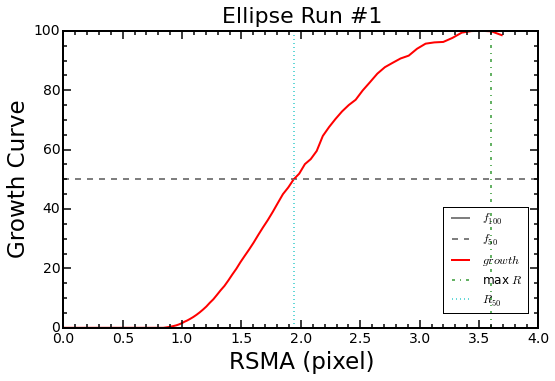

In [544]:
fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.1, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('RSMA (pixel)', fontsize=23)
ax.set_ylabel('Growth Curve', fontsize=23)

ax.axhline(100.0, linestyle='-', color='k', alpha=0.5, linewidth=2, 
           label='$f_{100}$')
ax.axhline(50.0,  linestyle='--', color='k', alpha=0.5, linewidth=2, 
           label='$f_{50}$')
ax.plot(ellipseOut1['rsma'], isoGrowthCurve1, '-', color='r', linewidth=2.0, 
        label='$growth$')
ax.axvline(maxIsoSma1**0.25, linestyle='-.', color='g', alpha=0.6, 
           linewidth=2, label='max $R$')

ax.axvline(isoRsma50_1, linestyle=':', color='c', alpha=0.6, linewidth=2, 
           label='$R_{50}$')
ax.legend(loc=[0.8, 0.05])

ax.set_title("Ellipse Run #1", fontsize=22)
ax.title.set_position((0.5,1.01))

## Overplot the Ellipse on the Image

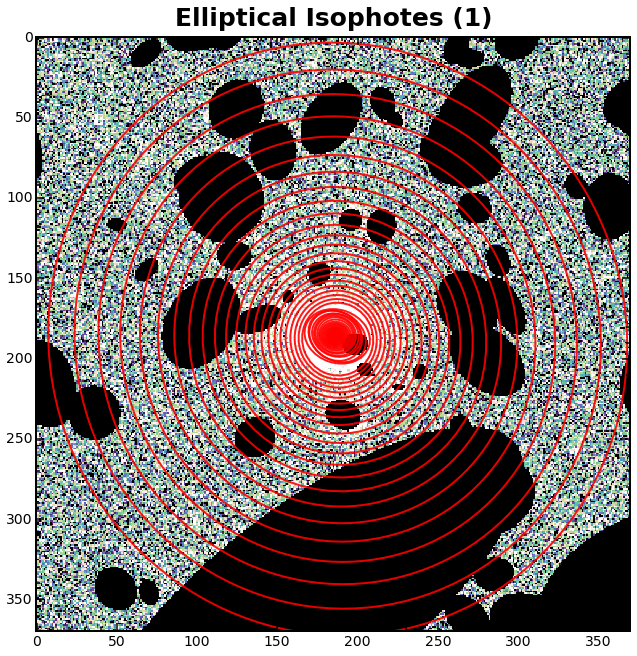

In [545]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1,
                    top=0.95, right=0.95)
ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
ax.set_title('Elliptical Isophotes (1)', fontsize=25, fontweight='bold')
ax.title.set_position((0.5,1.01))

# NaN-Mask the image
imgMsk = copy.deepcopy(img)
imin, imax = zscale(imgMsk, contrast=0.6, samples=500)
imgMsk[msk > 0] = np.nan 

# Color map
cmap = cubehelix.cmap(start=0.5, rot=-1.0, minSat=1.2, maxSat=1.2, 
                      minLight=0., maxLight=1., gamma=0.5)
cmap.set_bad('k',1.)

# Crop the image
if (galX > maxRad1) and (galY > maxRad1): 
    zoomReg = imgMsk[np.int(galX-maxRad1):np.int(galX+maxRad1), 
                     np.int(galY-maxRad1):np.int(galY+maxRad1)]
    # Define the new center of the cropped images
    xPad = (imgSizeX / 2.0 - maxRad1)
    yPad = (imgSizeY / 2.0 - maxRad1)
else: 
    zoomReg = imgMsk
    xPad = 0 
    yPad = 0

# Show the image
ax.imshow(np.arcsinh(zoomReg), interpolation="none", 
          vmin=imin, vmax=imax, cmap=cmap)

# Get the Shapes
ellipIso1 = convIso2Ell(ellipseOut1, xpad=xPad, ypad=yPad)

# Overlay the ellipses on the image
for e in ellipIso1:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.9)
    e.set_edgecolor('r')
    e.set_facecolor('none')
    e.set_linewidth(2.0)

In [546]:
def ellipseGetAvgCen(ellipseOut, isoRsma50, minSma=0.5, ratio=1.2):

    # Get the Average X0/Y0 
    radOuter = (isoRsma50 ** 4.0) * ratio 
    
    avgCenX = np.nanmedian(ellipseOut['x0'][np.logical_and((ellipseOut['sma'] <= radOuter), 
                                                           (ellipseOut['sma'] >= minSma))])
    print ellipseOut['x0'][np.logical_and((ellipseOut['sma'] <= radOuter), 
                                                           (ellipseOut['sma'] >= minSma))]
    avgCenY = np.nanmedian(ellipseOut['y0'][np.logical_and((ellipseOut['sma'] <= radOuter), 
                                                           (ellipseOut['sma'] >= minSma))])
    
    return avgCenX, avgCenY

print "The average X0/Y0 is %7.2f/%7.2f" % ellipseGetAvgCen(ellipseOut1, isoRsma50_1)

   x0   
--------
400.9116
400.9025
400.8924
400.8813
400.8689
400.8552
400.8476
400.8465
400.8696
400.8788
     ...
401.0165
401.0188
401.0078
401.0687
401.1534
401.2739
401.4755
401.3889
401.3066
401.7171
401.8196
Length = 37 rows
The average X0/Y0 is  400.94/ 400.94


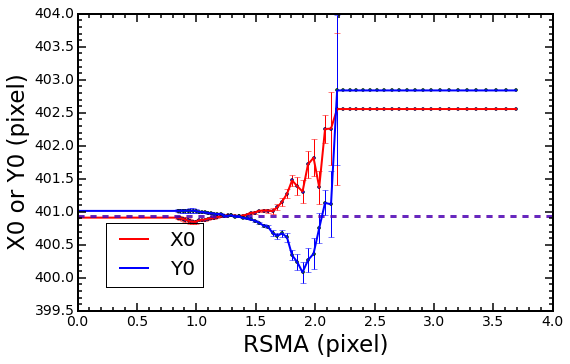

In [547]:
fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.1, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()
#ax.invert_yaxis()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('RSMA (pixel)',      fontsize=23)
ax.set_ylabel('X0 or Y0 (pixel)', fontsize=23)

ax.errorbar(ellipseOut1['rsma'], ellipseOut1['x0'], 
            yerr=ellipseOut1['x0_err'], fmt='o', markersize=3, ecolor='r')
ax.plot(ellipseOut1['rsma'], ellipseOut1['x0'], '-', 
        color='r', linewidth=2.0, label='X0')
ax.axhline(avgCenX, linestyle='--', color='r', alpha=0.6, linewidth=3.0)

ax.errorbar(ellipseOut1['rsma'], ellipseOut1['y0'], 
            yerr=ellipseOut1['y0_err'], fmt='o', markersize=3, ecolor='b')
ax.plot(ellipseOut1['rsma'], ellipseOut1['y0'], '-', 
        color='b', linewidth=2.0, label='Y0')
ax.axhline(avgCenY, linestyle='--', color='b', alpha=0.6, linewidth=3.0)

# Put legend on
ax.legend(loc=[0.06, 0.08], fontsize=20)

## Run 2: Fixed X0/Y0, Free Ellipticity/PA

In [115]:
outBin2 = imgFile.replace(".fits", "_ellipse_2.bin")
outTab2 = imgFile.replace(".fits", "_ellipse_2.tab")
outCdf2 = imgFile.replace(".fits", "_ellipse_2.cdf")

In [125]:
#Define parameters for the ellipse run
# 1. Initial guess of the central X, Y 
iraf.ellipse.geompar.x0         = avgCenX
iraf.ellipse.geompar.y0         = avgCenY
# 2. Initial guess of the ellipticity and PA of the first ISOPHOTE
iraf.ellipse.geompar.ellip0     = (1.0 - galQ)
iraf.ellipse.geompar.pa0        = galPA
# 3. Initial radius for ellipse fitting
iraf.ellipse.geompar.sma0       = iniSMA2
# 4. The minimum and maximum radius for the ellipse fitting
iraf.ellipse.geompar.minsma     = minSMA2
iraf.ellipse.geompar.maxsma     = maxSMA2
# 5. Parameters about the stepsize during the fitting.
iraf.ellipse.geompar.linear     = "no"
iraf.ellipse.geompar.step       = ellStep2
# 6. Do you want to allow the ellipse to decide the galaxy center during the
iraf.ellipse.geompar.recenter   = "no"
# 7. The next three parameters control the behavior of the fit
iraf.ellipse.controlpar.conver  = 2
iraf.ellipse.controlpar.hcenter = "yes"
iraf.ellipse.controlpar.hellip  = "no"
iraf.ellipse.controlpar.hpa     = "no"
# 8. Parameters about the iterations
# minit/maxit: minimun and maximum number of the iterations
iraf.ellipse.controlpar.minit   = 10
iraf.ellipse.controlpar.maxit   = 200
# 9. Threshold for the object locator algorithm
iraf.ellipse.controlpar.olthresh = 1.00000
# 10. Make sure the Interactive Mode is turned off
iraf.ellipse.interactive         = "no"
# 11. Magnitude Zeropoint 
iraf.ellipse.magpar.mag0         = zpPhoto
# 12. Sampler
iraf.ellipse.samplepar.integrmode  = intMode2  # "bi-linear" "mean" "median"
iraf.ellipse.samplepar.usclip      = uppClip2
iraf.ellipse.samplepar.lsclip      = lowClip2
iraf.ellipse.samplepar.nclip       = nClip2
iraf.ellipse.samplepar.fflag       = fracBad2
# 13. Optional Harmonics
iraf.ellipse.samplepar.harmonics   = '1,2'

In [126]:
# Check and remove outputs from the previous Ellipse run
if os.path.exists(outBin2):
    os.remove(outBin2)
    
# Start the fitting of the 1st round
iraf.ellipse(input=imgFile, output=outBin2)

Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   6.00     3.47(  0.15) 0.118(0.007)  86.32( 1.78) 0.064   36   0    20    0
   6.60     2.94(  0.14) 0.119(0.009)  84.23( 2.25) 0.074   39   0    10    0
   7.26     2.49(  0.15) 0.113(0.011)  86.02( 2.87) 0.092   43   0    10    0
   7.99     2.13(  0.16) 0.111(0.010) -89.17( 2.81) 0.092   47   0    10    0
   8.78     1.82(  0.14) 0.115(0.010) -81.71( 2.77) 0.089   52   0    10    0
   9.66     1.49(  0.15) 0.107(0.015) -75.20( 4.36) 0.139   57   0    10    0
  10.63     1.26(  0.20) 0.104(0.022) -71.26( 6.36) 0.175   63   0    10    0
  11.69     1.06(  0.19) 0.103(0.022) -73.23( 6.34) 0.178   64   5    10    0
  12.86     0.88(  0.16) 0.096(0.026) -65.11( 7.44) 0.219   70   7    10

In [127]:
# Dump the useful information into a ASCII table
iraf.tables()
iraf.ttools()

if os.path.exists(outTab2):
    os.remove(outTab2)
if os.path.exists(outCdf2):
    os.remove(outCdf2)

iraf.tdump.columns=''
iraf.tdump(outBin2, datafil=outTab2, cdfile=outCdf2)

IMAGE    t red_21572_Icut_ori.fits


In [138]:
ellipseOut2 = readEllipseOut(outTab2, zp=zpPhoto, pix=pixelScale, 
                             exptime=expTime, harmonic=True)

nIso2 = len(ellipseOut2)
print "%d elliptical isophotes have been extracted" % nIs2

maxRad2 = np.nanmax(ellipseOut2['sma'])
print "The maximum radius is %7.2f pixels" % maxRad2

64 elliptical isophotes have been extracted
The maximum radius is  185.48 pixels


/Users/songhuang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:58: RuntimeWarning: invalid value encountered in log10
/Users/songhuang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:60: RuntimeWarning: invalid value encountered in log10


## Overplot the Ellipse on the Image

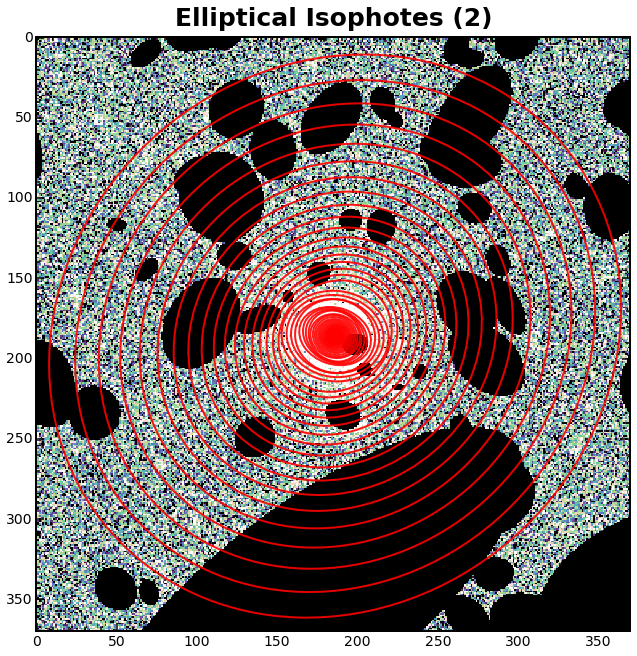

In [139]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1,
                    top=0.95, right=0.95)
ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
ax.set_title('Elliptical Isophotes (2)', fontsize=25, fontweight='bold')
ax.title.set_position((0.5,1.01))

# NaN-Mask the image
imgMsk = copy.deepcopy(img)
imin, imax = zscale(imgMsk, contrast=0.6, samples=500)
imgMsk[msk > 0] = np.nan 

# Color map
cmap = cubehelix.cmap(start=0.5, rot=-1.0, minSat=1.2, maxSat=1.2, 
                      minLight=0., maxLight=1., gamma=0.5)
cmap.set_bad('k',1.)

# Crop the image
if (galX > maxRad2) and (galY > maxRad2): 
    zoomReg = imgMsk[np.int(galX-maxRad2):np.int(galX+maxRad2), 
                     np.int(galY-maxRad2):np.int(galY+maxRad2)]
    # Define the new center of the cropped images
    xPad = (imgSizeX / 2.0 - maxRad2)
    yPad = (imgSizeY / 2.0 - maxRad2)
else: 
    zoomReg = imgMsk
    xPad = 0 
    yPad = 0

# Show the image
ax.imshow(np.arcsinh(zoomReg), interpolation="none", 
          vmin=imin, vmax=imax, cmap=cmap)

# Get the Shapes
ellipIso2 = convIso2Ell(ellipseOut2, xpad=xPad, ypad=yPad)

# Overlay the ellipses on the image
for e in ellipIso2:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.9)
    e.set_edgecolor('r')
    e.set_facecolor('none')
    e.set_linewidth(2.0)

In [174]:
# Get the Average Ellipticity and PA 
radInner =  4.0  # Need to have a way to define this limit
radOuter = 20.0

avgEll = np.nanmedian(ellipseOut2['ell'][np.logical_and((ellipseOut2['sma'] >= radInner), 
                                                        (ellipseOut2['sma'] <= radOuter))])
avgPA  = np.nanmedian(ellipseOut2['pa_norm'][np.logical_and((ellipseOut2['sma'] >= radInner), 
                                                            (ellipseOut2['sma'] <= radOuter))])

print "The median ellipticity of the inner region is %5.3f"    % avgEll 
print "The median position angle of the inner region is %7.2f" % avgPA 

The median ellipticity of the inner region is 0.107
The median position angle of the inner region is   98.29


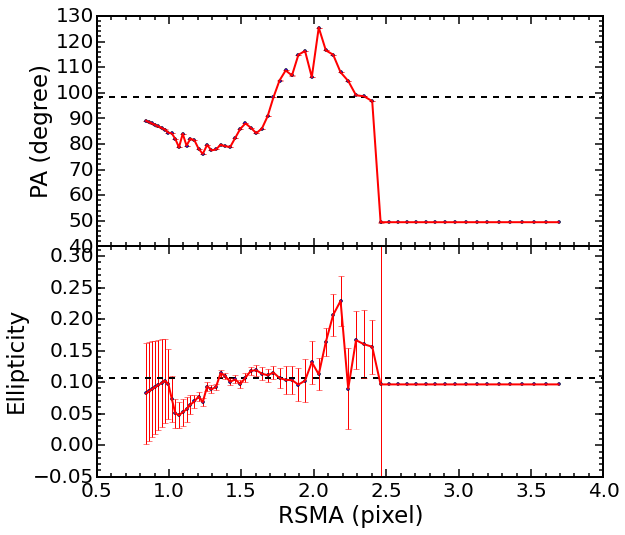

In [177]:
# Plot the elliptical and PA profiles

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1, 
                    top=0.95, right=0.95)

rec1 = [0.1, 0.1, 0.88, 0.4]
rec2 = [0.1, 0.5, 0.88, 0.4]

ax1 = plt.axes(rec1)
ax2 = plt.axes(rec2)

# Ellipticity 
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlabel('RSMA (pixel)', fontsize=23)
ax1.set_ylabel('Ellipticity',  fontsize=23)
ax1.set_ylim(-0.05, np.nanmax(ellipseOut2['ell'] + ellipseOut2['ell_err']))

ax1.axhline(avgEll, color='k', linestyle='--', linewidth=2)
ax1.errorbar(ellipseOut2['rsma'], ellipseOut2['ell'], 
            yerr=ellipseOut2['ell_err'], fmt='o', markersize=3, ecolor='r')
ax1.plot(ellipseOut2['rsma'], ellipseOut2['ell'], '-', 
        color='r', linewidth=2.0)
ax1.minorticks_on()


# Position Angle

ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel('PA (degree)',  fontsize=23)
#ax2.set_ylim(-0.05, np.nanmax(ellipseOut2['ell'] + ellipseOut2['ell_err']))

ax2.axhline(avgPA, color='k', linestyle='--', linewidth=2)
ax2.errorbar(ellipseOut2['rsma'], ellipseOut2['pa_norm'], 
            yerr=ellipseOut2['ell_err'], fmt='o', markersize=3, ecolor='r')
ax2.plot(ellipseOut2['rsma'], ellipseOut2['pa_norm'], '-', 
        color='r', linewidth=2.0)
ax2.xaxis.set_major_formatter(NullFormatter())
ax2.minorticks_on()

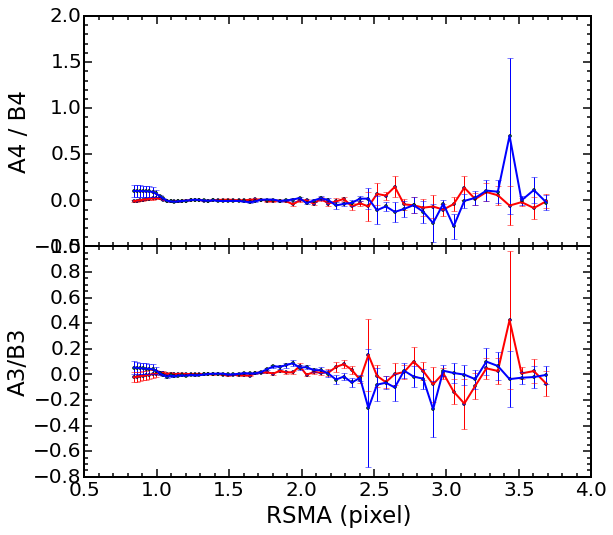

In [198]:
# Plot the A3/B3 and A4/B4

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1, 
                    top=0.95, right=0.95)

rec1 = [0.1, 0.1, 0.88, 0.4]
rec2 = [0.1, 0.5, 0.88, 0.4]

ax1 = plt.axes(rec1)
ax2 = plt.axes(rec2)

# Ellipticity 
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlabel('RSMA (pixel)', fontsize=23)
ax1.set_ylabel('A3/B3',  fontsize=23)
#ax1.set_ylim(-0.05, np.nanmax(ellipseOut2['b3'] + ellipseOut2['ell_err']))

ax1.errorbar(ellipseOut2['rsma'], ellipseOut2['a3'], 
            yerr=ellipseOut2['a3_err'], fmt='o', markersize=3, ecolor='r')
ax1.plot(ellipseOut2['rsma'], ellipseOut2['a3'], '-', 
        color='r', linewidth=2.0)
ax1.errorbar(ellipseOut2['rsma'], ellipseOut2['b3'], 
            yerr=ellipseOut2['b3_err'], fmt='o', markersize=3, ecolor='b')
ax1.plot(ellipseOut2['rsma'], ellipseOut2['b3'], '-', 
        color='b', linewidth=2.0)
ax1.minorticks_on()


# Position Angle

ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel('A4 / B4',  fontsize=23)

ax2.errorbar(ellipseOut2['rsma'], ellipseOut2['a4'], 
            yerr=ellipseOut2['a4_err'], fmt='o', markersize=3, ecolor='r')
ax2.plot(ellipseOut2['rsma'], ellipseOut2['a4'], '-', 
        color='r', linewidth=2.0)
ax2.errorbar(ellipseOut2['rsma'], ellipseOut2['b4'], 
            yerr=ellipseOut2['b4_err'], fmt='o', markersize=3, ecolor='b')
ax2.plot(ellipseOut2['rsma'], ellipseOut2['b4'], '-', 
        color='b', linewidth=2.0)

ax2.xaxis.set_major_formatter(NullFormatter())
ax2.minorticks_on()

## Run 3: Fixed X0/Y0, Ellipticity, and PA

In [178]:
outBin3 = imgFile.replace(".fits", "_ellipse_3.bin")
outTab3 = imgFile.replace(".fits", "_ellipse_3.tab")
outCdf3 = imgFile.replace(".fits", "_ellipse_3.cdf")

In [299]:
# The range for PA allowed by IRAF is [-90, 90]
import angles 
avgPaIraf = angles.normalize(avgPA, -90.0, 90.0)

#Define parameters for the ellipse run
# 1. Initial guess of the central X, Y 
iraf.ellipse.geompar.x0         = avgCenX
iraf.ellipse.geompar.y0         = avgCenY
# 2. Initial guess of the ellipticity and PA of the first ISOPHOTE
iraf.ellipse.geompar.ellip0     = avgEll
iraf.ellipse.geompar.pa0        = avgPaIraf
# 3. Initial radius for ellipse fitting
iraf.ellipse.geompar.sma0       = iniSMA3
# 4. The minimum and maximum radius for the ellipse fitting
iraf.ellipse.geompar.minsma     = minSMA3
#iraf.ellipse.geompar.maxsma     = maxSMA3
iraf.ellipse.geompar.maxsma     = 800
# 5. Parameters about the stepsize during the fitting.
iraf.ellipse.geompar.linear     = "no"
iraf.ellipse.geompar.step       = ellStep3
# 6. Do you want to allow the ellipse to decide the galaxy center during the
iraf.ellipse.geompar.recenter   = "no"
# 7. The next three parameters control the behavior of the fit
iraf.ellipse.controlpar.conver  = 2
iraf.ellipse.controlpar.hcenter = "yes"
iraf.ellipse.controlpar.hellip  = "yes"
iraf.ellipse.controlpar.hpa     = "yes"
# 8. Parameters about the iterations
# minit/maxit: minimun and maximum number of the iterations
iraf.ellipse.controlpar.minit   = 10
iraf.ellipse.controlpar.maxit   = 200
# 9. Threshold for the object locator algorithm
iraf.ellipse.controlpar.olthresh = 1.00000
# 10. Make sure the Interactive Mode is turned off
iraf.ellipse.interactive         = "no"
# 11. Magnitude Zeropoint 
iraf.ellipse.magpar.mag0         = zpPhoto
# 12. Sampler
iraf.ellipse.samplepar.integrmode  = intMode3  # "bi-linear" "mean" "median"
iraf.ellipse.samplepar.usclip      = uppClip3 
iraf.ellipse.samplepar.lsclip      = lowClip3
iraf.ellipse.samplepar.nclip       = nClip3
iraf.ellipse.samplepar.fflag       = fracBad3

In [300]:
# Check and remove outputs from the previous Ellipse run
if os.path.exists(outBin3):
    os.remove(outBin3)
    
# Start the fitting of the 1st round
iraf.ellipse(input=imgFile, output=outBin3)

Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   6.00     3.42(  0.14) 0.107(0.006) -81.71( 1.90) 0.064   32   4     1    0
   6.48     2.96(  0.13) 0.107(0.008) -81.71( 2.38) 0.079   35   4     1    0
   7.00     2.62(  0.15) 0.107(0.011) -81.71( 3.19) 0.096   34   8     1    0
   7.56     2.32(  0.15) 0.107(0.010) -81.71( 2.82) 0.091   44   1     1    0
   8.16     2.05(  0.16) 0.107(0.010) -81.71( 2.97) 0.091   49   0     1    0
   8.82     1.79(  0.14) 0.107(0.011) -81.71( 3.09) 0.093   52   0     1    0
   9.52     1.54(  0.15) 0.107(0.013) -81.71( 3.60) 0.107   57   0     1    0
  10.28     1.31(  0.15) 0.107(0.013) -81.71( 3.66) 0.140   56   5     1    0
  11.11     1.14(  0.16) 0.107(0.017) -81.71( 4.70) 0.170   58   8     1

In [308]:
# Dump the useful information into a ASCII table
iraf.tables()
iraf.ttools()

if os.path.exists(outTab3):
    os.remove(outTab3)
if os.path.exists(outCdf3):
    os.remove(outCdf3)

iraf.tdump.columns=''
iraf.tdump(outBin3, datafil=outTab3, cdfile=outCdf3)

IMAGE    t red_21572_Icut_ori.fits


In [312]:
ellipseOut3 = readEllipseOut(outTab3, zp=zpPhoto, pix=pixelScale, exptime=expTime)

nIso3 = len(ellipseOut3)
print "%d elliptical isophotes have been extracted" % nIso3

maxRad3 = np.nanmax(ellipseOut3['sma'])
print "The maximum radius is %7.2f pixels" % maxRad3

90 elliptical isophotes have been extracted
The maximum radius is  446.56 pixels


/Users/songhuang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:58: RuntimeWarning: invalid value encountered in log10
/Users/songhuang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:60: RuntimeWarning: invalid value encountered in log10
/Users/songhuang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:62: RuntimeWarning: invalid value encountered in log10


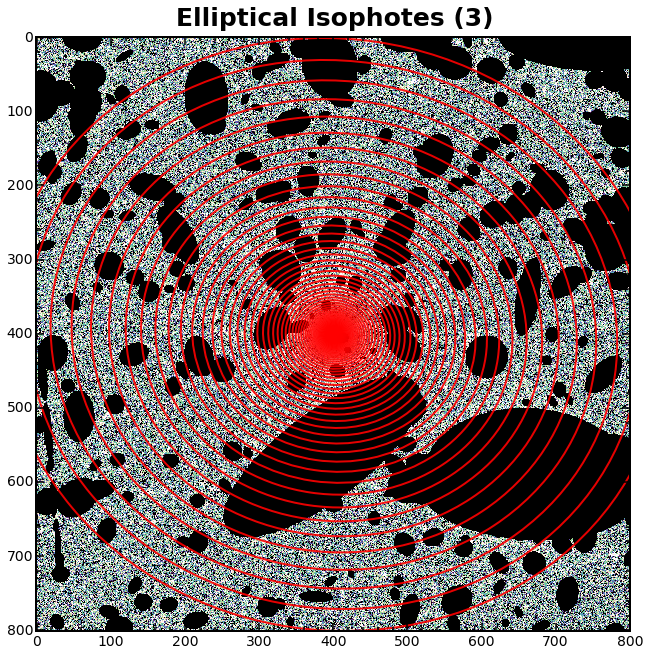

In [315]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1,
                    top=0.95, right=0.95)
ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
ax.set_title('Elliptical Isophotes (3)', fontsize=25, fontweight='bold')
ax.title.set_position((0.5,1.01))

# NaN-Mask the image
imgMsk = copy.deepcopy(img)
imin, imax = zscale(imgMsk, contrast=0.6, samples=500)
imgMsk[msk > 0] = np.nan 

# Color map
cmap = cubehelix.cmap(start=0.5, rot=-1.0, minSat=1.2, maxSat=1.2, 
                      minLight=0., maxLight=1., gamma=0.5)
cmap.set_bad('k',1.)

# Crop the image
if (galX > maxRad3) and (galY > maxRad3): 
    zoomReg = imgMsk[np.int(galX-maxRad3):np.int(galX+maxRad3), 
                     np.int(galY-maxRad3):np.int(galY+maxRad3)]
    # Define the new center of the cropped images
    xPad = (imgSizeX / 2.0 - maxRad3)
    yPad = (imgSizeY / 2.0 - maxRad3)
else: 
    zoomReg = imgMsk
    xPad = 0 
    yPad = 0

# Show the image
ax.imshow(np.arcsinh(zoomReg), interpolation="none", 
          vmin=imin, vmax=imax, cmap=cmap)

# Get the Shapes
ellipIso3 = convIso2Ell(ellipseOut3, xpad=xPad, ypad=yPad)

# Overlay the ellipses on the image
for e in ellipIso3:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.9)
    e.set_edgecolor('r')
    e.set_facecolor('none')
    e.set_linewidth(2.0)

/Users/songhuang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/Users/songhuang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: invalid value encountered in less


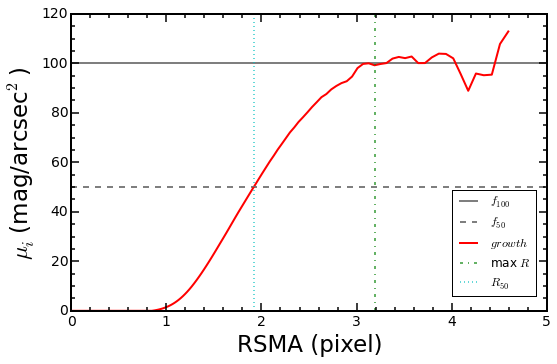

In [505]:
fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.1, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('RSMA (pixel)'                , fontsize=23)
ax.set_ylabel('${\mu}_{i}$ (mag/arcsec$^2$)', fontsize=23)

# Getting the growth curve
isoGrowthCurve, maxIsoRad = ellipseGetGrowthCurve(ellipseOut3, relThreshold=(5E-3))

ax.axhline(100.0, linestyle='-', color='k', alpha=0.5, linewidth=2, 
           label='$f_{100}$')
ax.axhline(50.0,  linestyle='--', color='k', alpha=0.5, linewidth=2, 
           label='$f_{50}$')
ax.plot(ellipseOut3['rsma'], isoGrowthCurve, '-', color='r', linewidth=2.0, 
        label='$growth$')
ax.axvline(maxIsoRad**0.25, linestyle='-.', color='g', alpha=0.6, 
           linewidth=2, label='max $R$')

isoRsma50 = ellipseGetR50(ellipseOut3['rsma'], isoGrowthCurve, simple=False)
ax.axvline(isoRsma50, linestyle=':', color='c', alpha=0.6, linewidth=2, 
           label='$R_{50}$')
ax.legend(loc=[0.8, 0.05])


## 4 1-D Surface Brightness Profile of PSF

In [213]:
# Files for PSF profiles
psfBin = psfFile.replace(".fits", "_ellip.bin")
psfTab = psfFile.replace(".fits", "_ellip.tab")
psfCdf = psfFile.replace(".fits", "_ellip.cdf")

In [214]:
# Read in the PSF image, get the center of PSF
psf = (fits.open(psfFile))[0].data
psfCenX, psfCenY = (psf.shape[0] / 2.0), (psf.shape[1] / 2.0)
psfMaxRad = psfCenX * np.sqrt(2.0)

In [215]:
#Define parameters for the ellipse run
# 1. Initial guess of the central X, Y 
iraf.ellipse.geompar.x0         = psfCenX
iraf.ellipse.geompar.y0         = psfCenY
# 2. Initial guess of the ellipticity and PA of the first ISOPHOTE
iraf.ellipse.geompar.ellip0     = 0.05
iraf.ellipse.geompar.pa0        = 0.00
# 3. Initial radius for ellipse fitting
iraf.ellipse.geompar.sma0       = 6.0
# 4. The minimum and maximum radius for the ellipse fitting
iraf.ellipse.geompar.minsma     = 0
iraf.ellipse.geompar.maxsma     = psfMaxRad
# 5. Parameters about the stepsize during the fitting.
iraf.ellipse.geompar.linear     = "no"
iraf.ellipse.geompar.step       = 0.08
# 6. Do you want to allow the ellipse to decide the galaxy center during the
iraf.ellipse.geompar.recenter   = "yes"
# 7. The next three parameters control the behavior of the fit
iraf.ellipse.controlpar.conver  = 2
iraf.ellipse.controlpar.hcenter = "yes"
iraf.ellipse.controlpar.hellip  = "yes"
iraf.ellipse.controlpar.hpa     = "yes"
# 8. Parameters about the iterations
# minit/maxit: minimun and maximum number of the iterations
iraf.ellipse.controlpar.minit   = 10
iraf.ellipse.controlpar.maxit   = 200
# 9. Threshold for the object locator algorithm
iraf.ellipse.controlpar.olthresh = 1.00000
# 10. Make sure the Interactive Mode is turned off
iraf.ellipse.interactive         = "no"
# 11. Magnitude Zeropoint 
iraf.ellipse.magpar.mag0         = zpPhoto
# 12. Sampler
iraf.ellipse.samplepar.integrmode  = "median"  # "bi-linear" "mean"
iraf.ellipse.samplepar.usclip      = 2.5 
iraf.ellipse.samplepar.lsclip      = 2.5
iraf.ellipse.samplepar.nclip       = 3
iraf.ellipse.samplepar.fflag       = 0.50

In [216]:
# Check and remove outputs from the previous Ellipse run
if os.path.exists(psfBin):
    os.remove(psfBin)
    
# Start the fitting of the 1st round
iraf.ellipse(input=psfFile, output=psfBin)

Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   6.00     0.00(  0.00) 0.050(0.000)   0.00( 0.04) INDEF   37   0     1    0
   6.48     0.00(  0.00) 0.050(0.000)   0.00( 0.03) INDEF   40   0     1    0
   7.00     0.00(  0.00) 0.050(INDEF)   0.00(INDEF) INDEF   43   0     1    4
   7.56     0.00(  0.00) 0.050(INDEF)   0.00(INDEF) INDEF   46   0     1    4
   8.16     0.00(  0.00) 0.050(INDEF)   0.00(INDEF) INDEF   50   0     1    4
   8.82     0.00(  0.00) 0.050(INDEF)   0.00(INDEF) INDEF   54   0     1    4
   9.52     0.00(  0.00) 0.050(INDEF)   0.00(INDEF) INDEF   57   1     1    4
  10.28     0.00(  0.00) 0.050(INDEF)   0.00(INDEF) INDEF   63   0     1    4
  11.11     0.00(  0.00) 0.050(INDEF)   0.00(INDEF) INDEF   62   6     1

In [217]:
# Dump the useful information into a ASCII table
iraf.tables()
iraf.ttools()

if os.path.exists(psfTab):
    os.remove(psfTab)
if os.path.exists(psfCdf):
    os.remove(psfCdf)

iraf.tdump.columns=''
iraf.tdump(psfBin, datafil=psfTab, cdfile=psfCdf)

IMAGE    t red_21572_Ipsf.fits


In [218]:
ellipsePsf = readEllipseOut(psfTab, zp=zpPhoto, pix=pixelScale, exptime=expTime)

nIsoPsf = len(ellipsePsf)
print "%d elliptical isophotes have been extracted from PSF image" % nIsoPsf

maxRadPsf = np.nanmax(ellipsePsf['sma'])
print "The maximum radius is %7.2f pixels" % maxRadPsf

51 elliptical isophotes have been extracted from PSF image
The maximum radius is   22.20 pixels


/Users/songhuang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:60: RuntimeWarning: invalid value encountered in log10


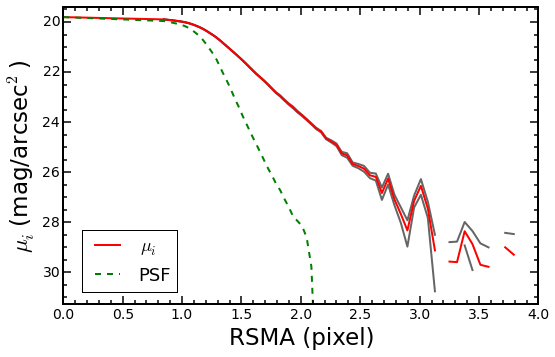

In [236]:
fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.1, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()
ax.invert_yaxis()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('RSMA (pixel)', fontsize=23)
ax.set_ylabel('${\mu}_{i}$ (mag/arcsec$^2$)', fontsize=23)

ax.plot(ellipseOut3['rsma'], ellipseOut3['sbp_uerr'], '-', 
        color='k', linewidth=2.0, alpha=0.6)
ax.plot(ellipseOut3['rsma'], ellipseOut3['sbp_lerr'], '-', 
        color='k', linewidth=2.0, alpha=0.6)
ax.plot(ellipseOut3['rsma'], ellipseOut3['sbp'], '-', 
        color='r', linewidth=2.0, label='${\mu}_{i}$')

sbpBuffer = 0.5  
minSbp, maxSbp = np.nanmin(ellipseOut3['sbp_uerr']), np.nanmax(ellipseOut3['sbp_lerr'])
ax.set_ylim((maxSbp+sbpBuffer), (minSbp-sbpBuffer))

# Overplot the profile for PSF 

# Find the offset at the center 
sbpOffsetPsf = ellipseOut3['sbp'][0] - ellipsePsf['sbp'][0]

ax.plot(ellipsePsf['rsma'], (ellipsePsf['sbp'] + sbpOffsetPsf), '--', 
        color='g', linewidth=2.0, label='PSF')

ax.legend(loc=[0.04,0.04], fontsize=18)

In [483]:
len(ellipseOut3['rsma'])

90